# Quadratic Assignment Problem

In this Jupyter Notebook, we will experiment with three solvers using Fixstars Amplify SDK

- Fixstars Amplify AE (GPU Annealer)

- Gurobi (On Device CPU)

- D-Wave Leap (Quantum Annealer)

In [1]:
# Example of cost matrix for the facility location problem
# Distance between locations
sample_distance = [
        [0, 1, 2, 3],
        [1, 0, 4, 2],
        [2, 4, 0, 1],
        [3, 2, 1, 0]
    ]

# Communication/Interaction Between Facilities
sample_interaction = [
        [0, 2, 3, 1],
        [2, 0, 1, 4],
        [3, 1, 0, 2],
        [1, 4, 2, 0]
    ]
# like packages sent between facilities per day

location_name = ["Site A", "Site B", "Site C", "Site D"]
facility_name = ['Warehouse', 'Factory', 'Office', 'Store']

In [ ]:
import sys
import os

# Add the project root directory to sys.path
sys.path.append(os.path.abspath('..'))

from graph import calculate_cost, assign_facilities

Assigning Randomly

Site A is assigned to Warehouse
Site B is assigned to Factory
Site C is assigned to Office
Site D is assigned to Store
Total Cost: 50


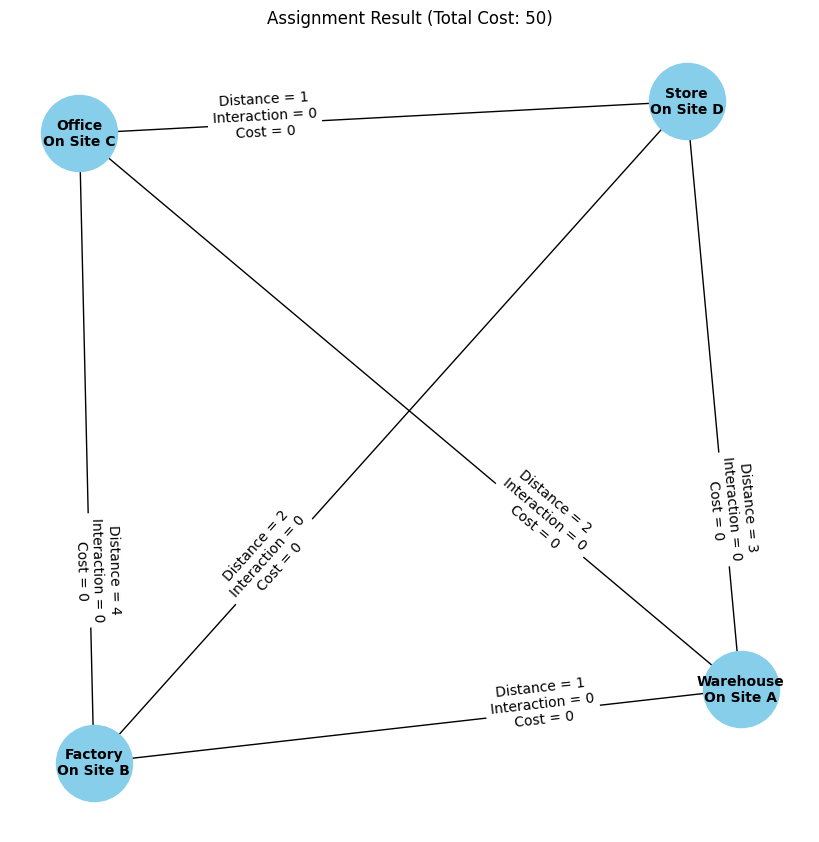

In [3]:
assign_facilities([0, 1, 2, 3], location_name, facility_name,
                  sample_distance, sample_interaction)

## Optimal Solution with Brute Force

Site A is assigned to Warehouse
Site B is assigned to Office
Site C is assigned to Factory
Site D is assigned to Store
Total Cost: 44


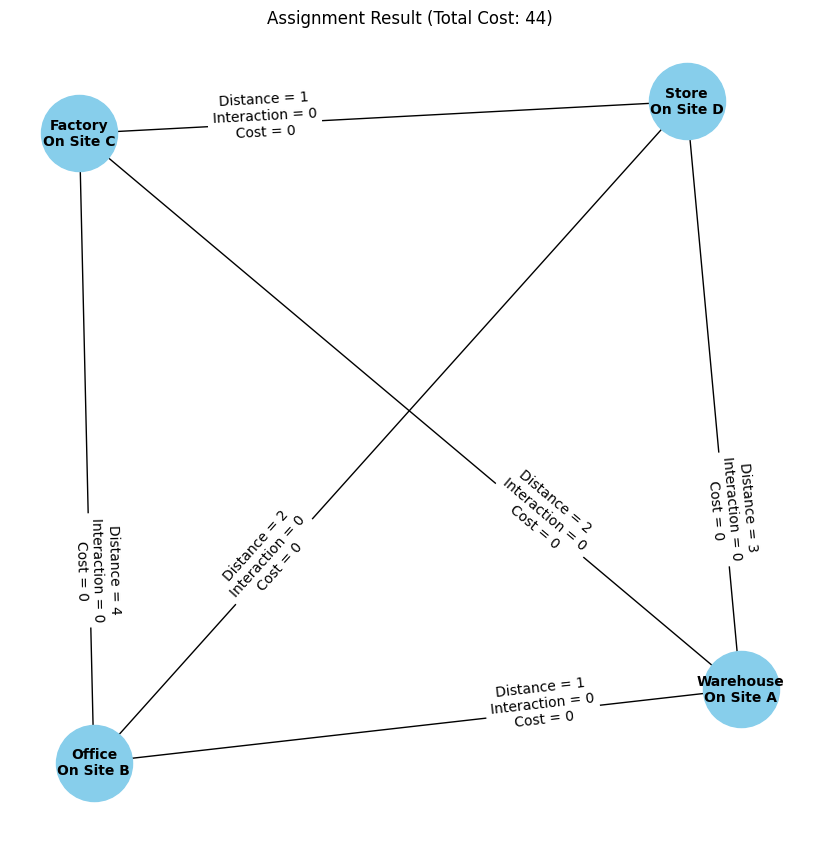

In [4]:
# Brute Force Solution from problem.ipynb

bf_solution = [0, 2, 1, 3]
assign_facilities(bf_solution, location_name, facility_name,
                  sample_distance, sample_interaction)

## Transforming problem into QUBO

In [5]:
from Utils.latex import obj_to_latex, con_to_latex
from IPython.display import display, Markdown

In [6]:
from model import create_qap_qp_model, solution_to_map

qp_model = create_qap_qp_model(sample_distance, sample_interaction)

display(Markdown("### Objective: Minimize"))
display(Markdown(obj_to_latex(qp_model["obj"])))


display(Markdown("### Constraint:"))
display(Markdown(con_to_latex(qp_model["c"])))

model = qp_model["model"]

### Objective: Minimize

Terms Count = 72, Unique Variable = 16  
$4 \cdot q_{0,0} \cdot q_{1,1} + 8 \cdot q_{0,0} \cdot q_{1,2} + 12 \cdot q_{0,0} \cdot q_{1,3} + 6 \cdot q_{0,0} \cdot q_{2,1} + 12 \cdot q_{0,0} \cdot q_{2,2} + 18 \cdot q_{0,0} \cdot q_{2,3} + 2 \cdot q_{0,0} \cdot q_{3,1} + 4 \cdot q_{0,0} \cdot q_{3,2} + 6 \cdot q_{0,0} \cdot q_{3,3} + 4 \cdot q_{0,1} \cdot q_{1,0} + 16 \cdot q_{0,1} \cdot q_{1,2} + 8 \cdot q_{0,1} \cdot q_{1,3} + 6 \cdot q_{0,1} \cdot q_{2,0} + 24 \cdot q_{0,1} \cdot q_{2,2} + 12 \cdot q_{0,1} \cdot q_{2,3} + 2 \cdot q_{0,1} \cdot q_{3,0} + 8 \cdot q_{0,1} \cdot q_{3,2} + 4 \cdot q_{0,1} \cdot q_{3,3} + 8 \cdot q_{0,2} \cdot q_{1,0} + 16 \cdot q_{0,2} \cdot q_{1,1} + 4 \cdot q_{0,2} \cdot q_{1,3} + 12 \cdot q_{0,2} \cdot q_{2,0} + 24 \cdot q_{0,2} \cdot q_{2,1} + 6 \cdot q_{0,2} \cdot q_{2,3} + 4 \cdot q_{0,2} \cdot q_{3,0} + 8 \cdot q_{0,2} \cdot q_{3,1} + 2 \cdot q_{0,2} \cdot q_{3,3} + 12 \cdot q_{0,3} \cdot q_{1,0} + 8 \cdot q_{0,3} \cdot q_{1,1} + 4 \cdot q_{0,3} \cdot q_{1,2} + 18 \cdot q_{0,3} \cdot q_{2,0} + 12 \cdot q_{0,3} \cdot q_{2,1} + 6 \cdot q_{0,3} \cdot q_{2,2} + 6 \cdot q_{0,3} \cdot q_{3,0} + 4 \cdot q_{0,3} \cdot q_{3,1} + 2 \cdot q_{0,3} \cdot q_{3,2} + 2 \cdot q_{1,0} \cdot q_{2,1} + 4 \cdot q_{1,0} \cdot q_{2,2} + 6 \cdot q_{1,0} \cdot q_{2,3} + 8 \cdot q_{1,0} \cdot q_{3,1} + 16 \cdot q_{1,0} \cdot q_{3,2} + 24 \cdot q_{1,0} \cdot q_{3,3} + 2 \cdot q_{1,1} \cdot q_{2,0} + 8 \cdot q_{1,1} \cdot q_{2,2} + 4 \cdot q_{1,1} \cdot q_{2,3} + 8 \cdot q_{1,1} \cdot q_{3,0} + 32 \cdot q_{1,1} \cdot q_{3,2} + 16 \cdot q_{1,1} \cdot q_{3,3} + 4 \cdot q_{1,2} \cdot q_{2,0} + 8 \cdot q_{1,2} \cdot q_{2,1} + 2 \cdot q_{1,2} \cdot q_{2,3} + 16 \cdot q_{1,2} \cdot q_{3,0} + 32 \cdot q_{1,2} \cdot q_{3,1} + 8 \cdot q_{1,2} \cdot q_{3,3} + 6 \cdot q_{1,3} \cdot q_{2,0} + 4 \cdot q_{1,3} \cdot q_{2,1} + 2 \cdot q_{1,3} \cdot q_{2,2} + 24 \cdot q_{1,3} \cdot q_{3,0} + 16 \cdot q_{1,3} \cdot q_{3,1} + 8 \cdot q_{1,3} \cdot q_{3,2} + 4 \cdot q_{2,0} \cdot q_{3,1} + 8 \cdot q_{2,0} \cdot q_{3,2} + 12 \cdot q_{2,0} \cdot q_{3,3} + 4 \cdot q_{2,1} \cdot q_{3,0} + 16 \cdot q_{2,1} \cdot q_{3,2} + 8 \cdot q_{2,1} \cdot q_{3,3} + 8 \cdot q_{2,2} \cdot q_{3,0} + 16 \cdot q_{2,2} \cdot q_{3,1} + 4 \cdot q_{2,2} \cdot q_{3,3} + 12 \cdot q_{2,3} \cdot q_{3,0} + 8 \cdot q_{2,3} \cdot q_{3,1} + 4 \cdot q_{2,3} \cdot q_{3,2}$

### Constraint:

Constraint Count: 8  
$q_{0,0} + q_{0,1} + q_{0,2} + q_{0,3} = 1$ (weight: 1)  
$q_{0,0} + q_{1,0} + q_{2,0} + q_{3,0} = 1$ (weight: 1)  
$q_{1,0} + q_{1,1} + q_{1,2} + q_{1,3} = 1$ (weight: 1)  
$q_{0,1} + q_{1,1} + q_{2,1} + q_{3,1} = 1$ (weight: 1)  
$q_{2,0} + q_{2,1} + q_{2,2} + q_{2,3} = 1$ (weight: 1)  
$q_{0,2} + q_{1,2} + q_{2,2} + q_{3,2} = 1$ (weight: 1)  
$q_{3,0} + q_{3,1} + q_{3,2} + q_{3,3} = 1$ (weight: 1)  
$q_{0,3} + q_{1,3} + q_{2,3} + q_{3,3} = 1$ (weight: 1)  


In [7]:
from amplify import solve

## Fixstars Amplify AE

In [8]:
# Initialise Fixstars Client
from Utils.solvers import GetFixstarClient

clientFS = GetFixstarClient()

# Solve set partitioning and view result
result = solve(model, clientFS)

print(result.best.objective)
print(result.best.values)

RuntimeError: result has no feasible solution

In [9]:
print(result.client_result)

{"execution_time":{"annealing_time":942.2817679999999,"queue_time":0.061149999999999996,"cpu_time":0.29217899999999997,"time_stamps":[37.139075]},"energies":[2.0],"spins":[[0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0]],"feasibilities":[false],"execution_parameters":{"num_gpus":1,"timeout":1000,"num_iterations":13,"penalty_calibration":true,"penalty_multipliers":[1.3600123983947654,1.5901999894135843,1.4456363540123496,1.5901999894135843,1.5901999894135843,1.4960136382342422,1.4960136382342422,1.4960136382342422],"version":"v0.8.7-V100"},"message":""}


## Gurobi

In [10]:
from Utils.solvers import GetGurobiClient

clientG = GetGurobiClient()
resultG = solve(model, clientG)

print(resultG.best.objective)
print(resultG.best.values)

Set parameter Username
44.0
{q_{0,0}: 0, q_{0,1}: 1, q_{0,2}: 0, q_{0,3}: 0, q_{1,0}: 0, q_{1,1}: 0, q_{1,2}: 0, q_{1,3}: 1, q_{2,0}: 1, q_{2,1}: 0, q_{2,2}: 0, q_{2,3}: 0, q_{3,0}: 0, q_{3,1}: 0, q_{3,2}: 1, q_{3,3}: 0}
Academic license - for non-commercial use only - expires 2025-10-14


Site A is assigned to Office
Site B is assigned to Warehouse
Site C is assigned to Store
Site D is assigned to Factory
Total Cost: 44


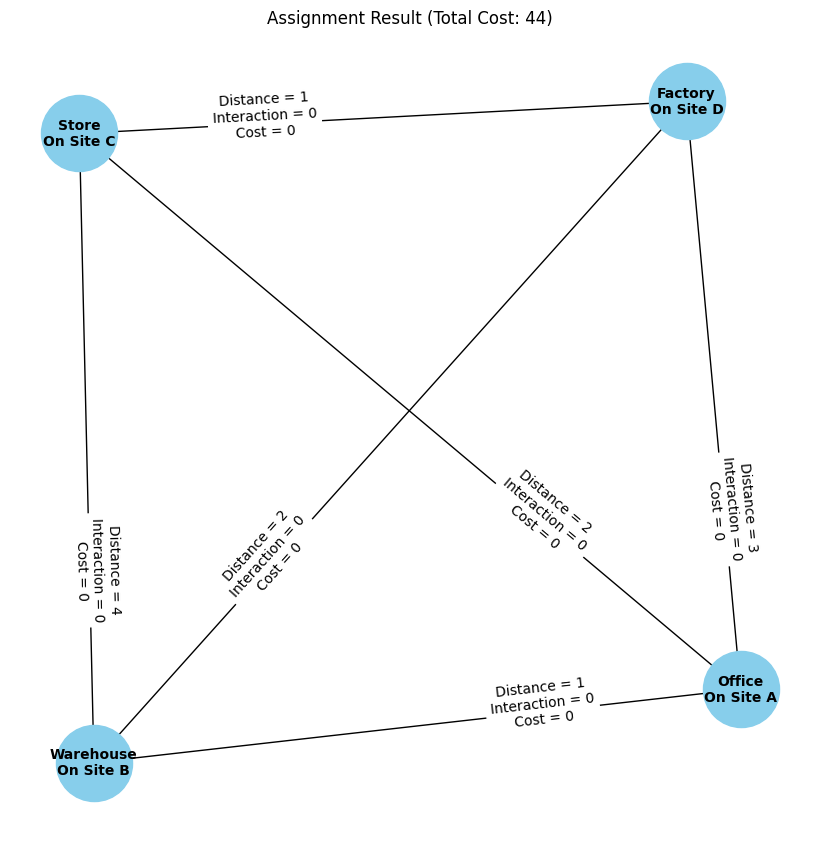

In [11]:
assign_facilities(solution_to_map(
    resultG, qp_model["q"], size=4),
    location_name, facility_name, sample_distance, sample_interaction)

## D-Wave

In [15]:
from Utils.solvers import GetDWaveClient

clientDWave = GetDWaveClient()

result = solve(model, clientDWave)

print(result.best.objective)
print(result.best.values)

RuntimeError: result has no feasible solution

## Try with Smaller Constraint

In [16]:
small_distance = [
        [0, 1, 1, 1],
        [1, 0, 1, 0],
        [1, 1, 0, 0],
        [1, 0, 0, 0]
    ]

small_interaction = [
        [0, 1, 1, 1],
        [1, 0, 0, 1],
        [1, 0, 0, 0],
        [1, 1, 0, 0]
    ]

small_model = create_qap_qp_model(small_distance, small_interaction)

display(Markdown("### Objective: Minimize"))
display(Markdown(obj_to_latex(small_model["obj"])))


display(Markdown("### Constraint:"))
display(Markdown(con_to_latex(small_model["c"])))

### Objective: Minimize

Terms Count = 32, Unique Variable = 16  
$2 \cdot q_{0,0} \cdot q_{1,1} + 2 \cdot q_{0,0} \cdot q_{1,2} + 2 \cdot q_{0,0} \cdot q_{1,3} + 2 \cdot q_{0,0} \cdot q_{2,1} + 2 \cdot q_{0,0} \cdot q_{2,2} + 2 \cdot q_{0,0} \cdot q_{2,3} + 2 \cdot q_{0,0} \cdot q_{3,1} + 2 \cdot q_{0,0} \cdot q_{3,2} + 2 \cdot q_{0,0} \cdot q_{3,3} + 2 \cdot q_{0,1} \cdot q_{1,0} + 2 \cdot q_{0,1} \cdot q_{1,2} + 2 \cdot q_{0,1} \cdot q_{2,0} + 2 \cdot q_{0,1} \cdot q_{2,2} + 2 \cdot q_{0,1} \cdot q_{3,0} + 2 \cdot q_{0,1} \cdot q_{3,2} + 2 \cdot q_{0,2} \cdot q_{1,0} + 2 \cdot q_{0,2} \cdot q_{1,1} + 2 \cdot q_{0,2} \cdot q_{2,0} + 2 \cdot q_{0,2} \cdot q_{2,1} + 2 \cdot q_{0,2} \cdot q_{3,0} + 2 \cdot q_{0,2} \cdot q_{3,1} + 2 \cdot q_{0,3} \cdot q_{1,0} + 2 \cdot q_{0,3} \cdot q_{2,0} + 2 \cdot q_{0,3} \cdot q_{3,0} + 2 \cdot q_{1,0} \cdot q_{3,1} + 2 \cdot q_{1,0} \cdot q_{3,2} + 2 \cdot q_{1,0} \cdot q_{3,3} + 2 \cdot q_{1,1} \cdot q_{3,0} + 2 \cdot q_{1,1} \cdot q_{3,2} + 2 \cdot q_{1,2} \cdot q_{3,0} + 2 \cdot q_{1,2} \cdot q_{3,1} + 2 \cdot q_{1,3} \cdot q_{3,0}$

### Constraint:

Constraint Count: 8  
$q_{0,0} + q_{0,1} + q_{0,2} + q_{0,3} = 1$ (weight: 1)  
$q_{0,0} + q_{1,0} + q_{2,0} + q_{3,0} = 1$ (weight: 1)  
$q_{1,0} + q_{1,1} + q_{1,2} + q_{1,3} = 1$ (weight: 1)  
$q_{0,1} + q_{1,1} + q_{2,1} + q_{3,1} = 1$ (weight: 1)  
$q_{2,0} + q_{2,1} + q_{2,2} + q_{2,3} = 1$ (weight: 1)  
$q_{0,2} + q_{1,2} + q_{2,2} + q_{3,2} = 1$ (weight: 1)  
$q_{3,0} + q_{3,1} + q_{3,2} + q_{3,3} = 1$ (weight: 1)  
$q_{0,3} + q_{1,3} + q_{2,3} + q_{3,3} = 1$ (weight: 1)  


Site A is assigned to Warehouse
Site B is assigned to Factory
Site C is assigned to Office
Site D is assigned to Store
Total Cost: 6


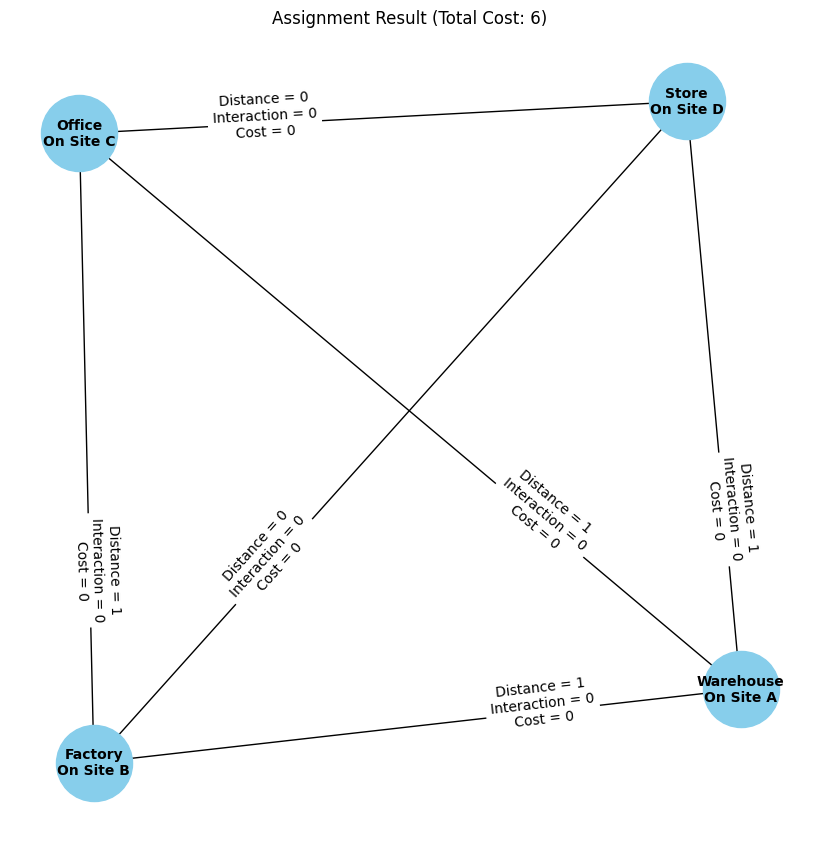

In [17]:
# Random Solution

assign_facilities([0, 1, 2, 3], location_name, facility_name,
                  small_distance, small_interaction)

## Find best solution with Gurobi

Because for now, it works

4.0Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14

{q_{0,0}: 0, q_{0,1}: 0, q_{0,2}: 0, q_{0,3}: 1, q_{1,0}: 1, q_{1,1}: 0, q_{1,2}: 0, q_{1,3}: 0, q_{2,0}: 0, q_{2,1}: 0, q_{2,2}: 1, q_{2,3}: 0, q_{3,0}: 0, q_{3,1}: 1, q_{3,2}: 0, q_{3,3}: 0}
Site A is assigned to Factory
Site B is assigned to Store
Site C is assigned to Office
Site D is assigned to Warehouse
Total Cost: 4


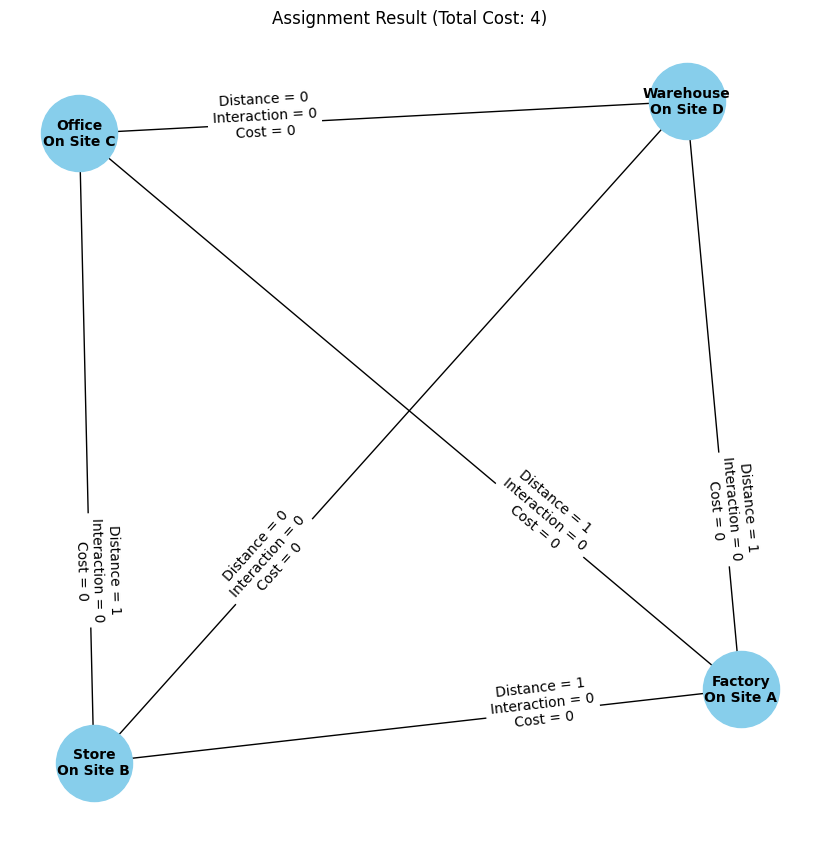

In [18]:
result_small_gurobi = solve(small_model["model"], clientG)

print(result_small_gurobi.best.objective)
print(result_small_gurobi.best.values)
assign_facilities(solution_to_map(
    result_small_gurobi, small_model["q"]),
    location_name, facility_name, small_distance, small_interaction)

## Giving Fixstars and D-Wave second try

4.0
{q_{0,0}: 0, q_{0,1}: 0, q_{0,2}: 0, q_{0,3}: 1, q_{1,0}: 0, q_{1,1}: 1, q_{1,2}: 0, q_{1,3}: 0, q_{2,0}: 1, q_{2,1}: 0, q_{2,2}: 0, q_{2,3}: 0, q_{3,0}: 0, q_{3,1}: 0, q_{3,2}: 1, q_{3,3}: 0}
Site A is assigned to Office
Site B is assigned to Factory
Site C is assigned to Store
Site D is assigned to Warehouse
Total Cost: 4


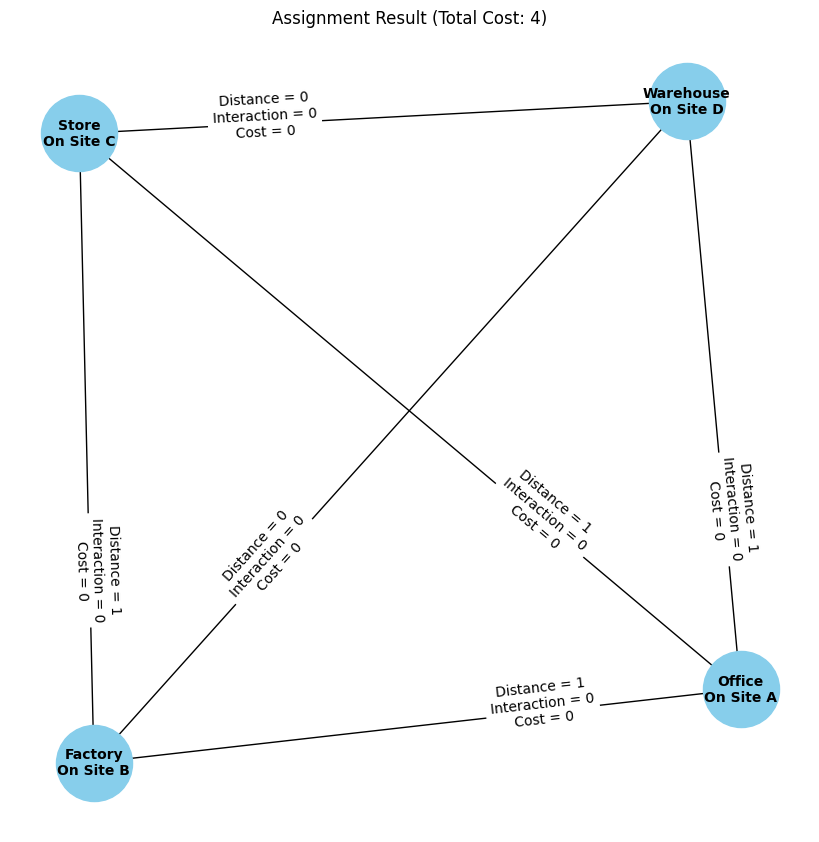

In [20]:
result_small_fixstars = solve(small_model["model"], clientFS)

print(result_small_fixstars.best.objective)
print(result_small_fixstars.best.values)
assign_facilities(solution_to_map(
    result_small_fixstars, small_model["q"]),
    location_name, facility_name, small_distance, small_interaction)

In [21]:
print(result_small_fixstars.client_result)

{"execution_time":{"annealing_time":986.0186779999999,"queue_time":0.053986,"cpu_time":0.27294299999999994,"time_stamps":[37.017678999999994,463.73995099999996]},"energies":[4.0],"spins":[[0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0]],"feasibilities":[true],"execution_parameters":{"num_gpus":1,"timeout":1000,"num_iterations":14,"penalty_calibration":true,"penalty_multipliers":[1.4682724529205793,1.472949858337145,1.1,1.095,1.1589629418952252,1.1569723555321394,1.1565752837352643,1.1577675440516706],"version":"v0.8.7-V100"},"message":""}


4.0
{q_{0,0}: 0, q_{0,1}: 0, q_{0,2}: 0, q_{0,3}: 1, q_{1,0}: 1, q_{1,1}: 0, q_{1,2}: 0, q_{1,3}: 0, q_{2,0}: 0, q_{2,1}: 0, q_{2,2}: 1, q_{2,3}: 0, q_{3,0}: 0, q_{3,1}: 1, q_{3,2}: 0, q_{3,3}: 0}
Site A is assigned to Factory
Site B is assigned to Store
Site C is assigned to Office
Site D is assigned to Warehouse
Total Cost: 4


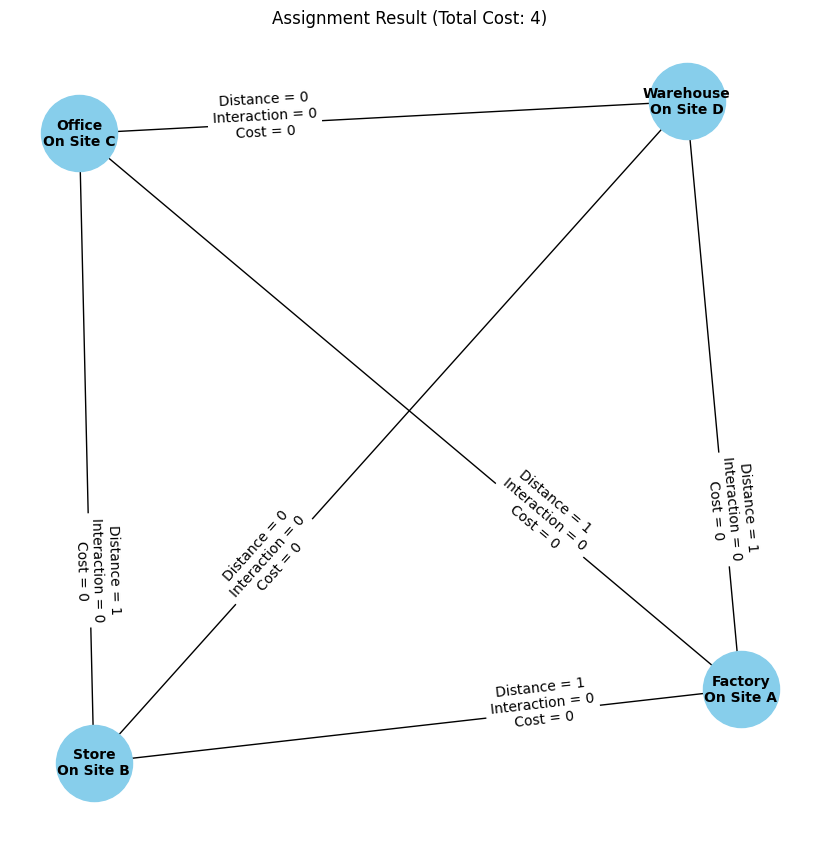

In [22]:
result_small_dwave = solve(small_model["model"], clientDWave)

print(result_small_dwave.best.objective)
print(result_small_dwave.best.values)
assign_facilities(solution_to_map(
    result_small_dwave, small_model["q"]),
    location_name, facility_name, small_distance, small_interaction)

## QAP Complexity

Where $N$ = Number of Facilities = Number of Locations

- Variables = $N^2$ = $\mathrm{O}(N^2)$
- Objective Terms = $\frac{N^4 - 2N^3 + n^2}{2}$ = $\mathrm{O}(N^4)$
- Constraints = $2N$ = $\mathrm{O}(N)$

## First Experiment Conclusion

Gurobi does not use Annealing method (I guess) and can solve the problem easily

However, Annealing like Qiskit, D-Wave, and Fixstars failed to solve problem
that is too big.

After trying to look into the problem, the result of Fixstars is

```json
{
  "execution_time": {
    "annealing_time": 9984.25569,
    "queue_time": 0.052541,
    "cpu_time": 0.28541999999999995,
    "time_stamps": [32.096686999999996]
  },
  "energies": [2.0],
  "spins": [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]],
  "feasibilities": [false],
  "execution_parameters": {
    "num_gpus": 1,
    "timeout": 10000,
    "num_iterations": 138,
    "penalty_calibration": true,
    "penalty_multipliers": [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0],
    "version": "v0.8.7-V100"
  },
  "message": ""
}
```

The energy of $2.0$ is less than optimal ($44$) and you can see from spin that
it violates the constraints. According to Fixstars Amplify docs:

https://amplify.fixstars.com/en/docs/amplify/v0/constraint.html

> However, QUBO and Ising models, which you need to use for quantum annealing machines and Ising machines, cannot directly handle such constraints. One basic approach to deal with constraints is to prepare a penalty function $g$, which takes the minimum value if and only if the constraint is satisfied, and adds it to the original objective $f$ function with a weight $\lambda$.

There is a possiblity that the penalty weight is too low, leading to lower energy than optimal.

So, I tried to fix this by manually increasing the penalty weight.

In [23]:
from IPython.display import display, Markdown
import time
from typing import List


def compareSolvers(
        distance_matrix: List[List[int]],
        interaction_matrix: List[List[int]],
        weight=1,
        short=False):
    size = len(distance_matrix)

    create_model_start = time.time()
    qp_model = create_qap_qp_model(distance_matrix, interaction_matrix, weight)
    create_model_end = time.time()

    print(f"Create model took {create_model_end -
          create_model_start:.6f} seconds")

    render_md_start = time.time()
    display(Markdown("### Objective: Minimize"))
    display(Markdown(obj_to_latex(qp_model["obj"], short)))

    display(Markdown("### Constraint:"))
    display(Markdown(con_to_latex(qp_model["c"], short)))

    render_md_end = time.time()
    print(f"Render Markdown took {
          render_md_end - render_md_start:.6f} seconds")

    random_solution = list(range(size))
    random_result = calculate_cost(
        random_solution, distance_matrix, interaction_matrix)

    print(f"Random Solution Cost: {random_result}")

    # Gurobi
    print("=== Gurobi ===")

    try:
        resultG = solve(qp_model["model"], clientG)
        print(f"Gurobi Solution Cost: {resultG.best.objective}")
    except:
        print("Gurobi Failed")
        try:
            print(resultG.client_result)
        except:
            pass
    finally:
        try:
            print(f"Gurobi took {resultG.execution_time}")
        except:
            pass

    # Fixstars
    print("=== Fixstars ===")

    try:
        resultFS = solve(qp_model["model"], clientFS)
        print(f"Fixstars Solution Cost: {resultFS.best.objective}")
    except:
        print("Fixstars Failed")
        try:
            print(resultFS.client_result)
        except:
            pass
    finally:
        try:
            print(f"Fixstars took {resultFS.execution_time}")
        except:
            pass

    # DWave
    print("=== DWave ===")

    try:
        resultDWave = solve(qp_model["model"], clientDWave)
        print(f"DWave Solution Cost: {resultDWave.best.objective}")
    except:
        print("DWave Failed")
        try:
            print(resultDWave.client_result)
        except:
            pass
    finally:
        try:
            print(f"DWave took {resultDWave.execution_time}")
        except:
            pass

    return (resultG, resultFS, resultDWave)

In [32]:
_ = compareSolvers(
    [
        [0, 1, 2],
        [1, 0, 3],
        [2, 3, 0]
    ],
    [
        [0, 4, 5],
        [4, 0, 6],
        [5, 6, 0]
    ], 20)

# Weight: Fixstars/D-Wave
# 1M: All Best Solution
# 10: All Pass (That was Last Week)
# This week, ~15-20 is required for Fixstars

Create model took 0.000317 seconds


### Objective: Minimize

Terms Count = 18, Unique Variable = 9  
$8 \cdot q_{0,0} \cdot q_{1,1} + 16 \cdot q_{0,0} \cdot q_{1,2} + 10 \cdot q_{0,0} \cdot q_{2,1} + 20 \cdot q_{0,0} \cdot q_{2,2} + 8 \cdot q_{0,1} \cdot q_{1,0} + 24 \cdot q_{0,1} \cdot q_{1,2} + 10 \cdot q_{0,1} \cdot q_{2,0} + 30 \cdot q_{0,1} \cdot q_{2,2} + 16 \cdot q_{0,2} \cdot q_{1,0} + 24 \cdot q_{0,2} \cdot q_{1,1} + 20 \cdot q_{0,2} \cdot q_{2,0} + 30 \cdot q_{0,2} \cdot q_{2,1} + 12 \cdot q_{1,0} \cdot q_{2,1} + 24 \cdot q_{1,0} \cdot q_{2,2} + 12 \cdot q_{1,1} \cdot q_{2,0} + 36 \cdot q_{1,1} \cdot q_{2,2} + 24 \cdot q_{1,2} \cdot q_{2,0} + 36 \cdot q_{1,2} \cdot q_{2,1}$

### Constraint:

Constraint Count: 6  
$q_{0,0} + q_{0,1} + q_{0,2} = 1$ (weight: 20)  
$q_{0,0} + q_{1,0} + q_{2,0} = 1$ (weight: 20)  
$q_{1,0} + q_{1,1} + q_{1,2} = 1$ (weight: 20)  
$q_{0,1} + q_{1,1} + q_{2,1} = 1$ (weight: 20)  
$q_{2,0} + q_{2,1} + q_{2,2} = 1$ (weight: 20)  
$q_{0,2} + q_{1,2} + q_{2,2} = 1$ (weight: 20)  


Render Markdown took 0.006324 seconds
Random Solution Cost: 64
=== Gurobi ===
Gurobi Solution Cost: 56.0
Gurobi took 0:00:00.004060
=== Fixstars ===
Set parameter Username
Fixstars Solution Cost: 56.0
Fixstars took 0:00:00.975235
=== DWave ===
Academic license - for non-commercial use only - expires 2025-10-14
DWave Solution Cost: 56.0
DWave took 0:00:00.142362


In [33]:
_ = compareSolvers(
    [
        [0, 1, 0, 2],
        [1, 0, 1, 0],
        [0, 1, 0, 2],
        [2, 0, 2, 0]
    ],
    [
        [0, 2, 0, 1],
        [2, 0, 2, 0],
        [0, 2, 0, 1],
        [1, 0, 1, 0]
    ], 3)

Create model took 0.000699 seconds


### Objective: Minimize

Terms Count = 32, Unique Variable = 16  
$4 \cdot q_{0,0} \cdot q_{1,1} + 8 \cdot q_{0,0} \cdot q_{1,3} + 2 \cdot q_{0,0} \cdot q_{3,1} + 4 \cdot q_{0,0} \cdot q_{3,3} + 4 \cdot q_{0,1} \cdot q_{1,0} + 4 \cdot q_{0,1} \cdot q_{1,2} + 2 \cdot q_{0,1} \cdot q_{3,0} + 2 \cdot q_{0,1} \cdot q_{3,2} + 4 \cdot q_{0,2} \cdot q_{1,1} + 8 \cdot q_{0,2} \cdot q_{1,3} + 2 \cdot q_{0,2} \cdot q_{3,1} + 4 \cdot q_{0,2} \cdot q_{3,3} + 8 \cdot q_{0,3} \cdot q_{1,0} + 8 \cdot q_{0,3} \cdot q_{1,2} + 4 \cdot q_{0,3} \cdot q_{3,0} + 4 \cdot q_{0,3} \cdot q_{3,2} + 4 \cdot q_{1,0} \cdot q_{2,1} + 8 \cdot q_{1,0} \cdot q_{2,3} + 4 \cdot q_{1,1} \cdot q_{2,0} + 4 \cdot q_{1,1} \cdot q_{2,2} + 4 \cdot q_{1,2} \cdot q_{2,1} + 8 \cdot q_{1,2} \cdot q_{2,3} + 8 \cdot q_{1,3} \cdot q_{2,0} + 8 \cdot q_{1,3} \cdot q_{2,2} + 2 \cdot q_{2,0} \cdot q_{3,1} + 4 \cdot q_{2,0} \cdot q_{3,3} + 2 \cdot q_{2,1} \cdot q_{3,0} + 2 \cdot q_{2,1} \cdot q_{3,2} + 2 \cdot q_{2,2} \cdot q_{3,1} + 4 \cdot q_{2,2} \cdot q_{3,3} + 4 \cdot q_{2,3} \cdot q_{3,0} + 4 \cdot q_{2,3} \cdot q_{3,2}$

### Constraint:

Constraint Count: 8  
$q_{0,0} + q_{0,1} + q_{0,2} + q_{0,3} = 1$ (weight: 3)  
$q_{0,0} + q_{1,0} + q_{2,0} + q_{3,0} = 1$ (weight: 3)  
$q_{1,0} + q_{1,1} + q_{1,2} + q_{1,3} = 1$ (weight: 3)  
$q_{0,1} + q_{1,1} + q_{2,1} + q_{3,1} = 1$ (weight: 3)  
$q_{2,0} + q_{2,1} + q_{2,2} + q_{2,3} = 1$ (weight: 3)  
$q_{0,2} + q_{1,2} + q_{2,2} + q_{3,2} = 1$ (weight: 3)  
$q_{3,0} + q_{3,1} + q_{3,2} + q_{3,3} = 1$ (weight: 3)  
$q_{0,3} + q_{1,3} + q_{2,3} + q_{3,3} = 1$ (weight: 3)  


Render Markdown took 0.004636 seconds
Random Solution Cost: 16
=== Gurobi ===
Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14
Gurobi Solution Cost: 8.0
Gurobi took 0:00:00.005294
=== Fixstars ===
Fixstars Solution Cost: 8.0
Fixstars took 0:00:00.982051
=== DWave ===
DWave Solution Cost: 8.0
DWave took 0:00:00.190521


Example of when D-Wave gives not optimal solution

In [36]:
_ = compareSolvers(
    [
        [0, 1, 2, 3, 4],
        [1, 0, 1, 2, 3],
        [2, 1, 0, 1, 2],
        [3, 2, 1, 0, 1],
        [4, 3, 2, 1, 0]
    ],
    [
        [0, 5, 6, 7, 8],
        [5, 0, 3, 2, 1],
        [6, 3, 0, 6, 9],
        [7, 2, 6, 0, 0],
        [8, 1, 9, 0, 0]
    ], 36)

Create model took 0.001500 seconds


### Objective: Minimize

Terms Count = 180, Unique Variable = 25  
$10 \cdot q_{0,0} \cdot q_{1,1} + 20 \cdot q_{0,0} \cdot q_{1,2} + 30 \cdot q_{0,0} \cdot q_{1,3} + 40 \cdot q_{0,0} \cdot q_{1,4} + 12 \cdot q_{0,0} \cdot q_{2,1} + 24 \cdot q_{0,0} \cdot q_{2,2} + 36 \cdot q_{0,0} \cdot q_{2,3} + 48 \cdot q_{0,0} \cdot q_{2,4} + 14 \cdot q_{0,0} \cdot q_{3,1} + 28 \cdot q_{0,0} \cdot q_{3,2} + 42 \cdot q_{0,0} \cdot q_{3,3} + 56 \cdot q_{0,0} \cdot q_{3,4} + 16 \cdot q_{0,0} \cdot q_{4,1} + 32 \cdot q_{0,0} \cdot q_{4,2} + 48 \cdot q_{0,0} \cdot q_{4,3} + 64 \cdot q_{0,0} \cdot q_{4,4} + 10 \cdot q_{0,1} \cdot q_{1,0} + 10 \cdot q_{0,1} \cdot q_{1,2} + 20 \cdot q_{0,1} \cdot q_{1,3} + 30 \cdot q_{0,1} \cdot q_{1,4} + 12 \cdot q_{0,1} \cdot q_{2,0} + 12 \cdot q_{0,1} \cdot q_{2,2} + 24 \cdot q_{0,1} \cdot q_{2,3} + 36 \cdot q_{0,1} \cdot q_{2,4} + 14 \cdot q_{0,1} \cdot q_{3,0} + 14 \cdot q_{0,1} \cdot q_{3,2} + 28 \cdot q_{0,1} \cdot q_{3,3} + 42 \cdot q_{0,1} \cdot q_{3,4} + 16 \cdot q_{0,1} \cdot q_{4,0} + 16 \cdot q_{0,1} \cdot q_{4,2} + 32 \cdot q_{0,1} \cdot q_{4,3} + 48 \cdot q_{0,1} \cdot q_{4,4} + 20 \cdot q_{0,2} \cdot q_{1,0} + 10 \cdot q_{0,2} \cdot q_{1,1} + 10 \cdot q_{0,2} \cdot q_{1,3} + 20 \cdot q_{0,2} \cdot q_{1,4} + 24 \cdot q_{0,2} \cdot q_{2,0} + 12 \cdot q_{0,2} \cdot q_{2,1} + 12 \cdot q_{0,2} \cdot q_{2,3} + 24 \cdot q_{0,2} \cdot q_{2,4} + 28 \cdot q_{0,2} \cdot q_{3,0} + 14 \cdot q_{0,2} \cdot q_{3,1} + 14 \cdot q_{0,2} \cdot q_{3,3} + 28 \cdot q_{0,2} \cdot q_{3,4} + 32 \cdot q_{0,2} \cdot q_{4,0} + 16 \cdot q_{0,2} \cdot q_{4,1} + 16 \cdot q_{0,2} \cdot q_{4,3} + 32 \cdot q_{0,2} \cdot q_{4,4} + 30 \cdot q_{0,3} \cdot q_{1,0} + 20 \cdot q_{0,3} \cdot q_{1,1} + 10 \cdot q_{0,3} \cdot q_{1,2} + 10 \cdot q_{0,3} \cdot q_{1,4} + 36 \cdot q_{0,3} \cdot q_{2,0} + 24 \cdot q_{0,3} \cdot q_{2,1} + 12 \cdot q_{0,3} \cdot q_{2,2} + 12 \cdot q_{0,3} \cdot q_{2,4} + 42 \cdot q_{0,3} \cdot q_{3,0} + 28 \cdot q_{0,3} \cdot q_{3,1} + 14 \cdot q_{0,3} \cdot q_{3,2} + 14 \cdot q_{0,3} \cdot q_{3,4} + 48 \cdot q_{0,3} \cdot q_{4,0} + 32 \cdot q_{0,3} \cdot q_{4,1} + 16 \cdot q_{0,3} \cdot q_{4,2} + 16 \cdot q_{0,3} \cdot q_{4,4} + 40 \cdot q_{0,4} \cdot q_{1,0} + 30 \cdot q_{0,4} \cdot q_{1,1} + 20 \cdot q_{0,4} \cdot q_{1,2} + 10 \cdot q_{0,4} \cdot q_{1,3} + 48 \cdot q_{0,4} \cdot q_{2,0} + 36 \cdot q_{0,4} \cdot q_{2,1} + 24 \cdot q_{0,4} \cdot q_{2,2} + 12 \cdot q_{0,4} \cdot q_{2,3} + 56 \cdot q_{0,4} \cdot q_{3,0} + 42 \cdot q_{0,4} \cdot q_{3,1} + 28 \cdot q_{0,4} \cdot q_{3,2} + 14 \cdot q_{0,4} \cdot q_{3,3} + 64 \cdot q_{0,4} \cdot q_{4,0} + 48 \cdot q_{0,4} \cdot q_{4,1} + 32 \cdot q_{0,4} \cdot q_{4,2} + 16 \cdot q_{0,4} \cdot q_{4,3} + 6 \cdot q_{1,0} \cdot q_{2,1} + 12 \cdot q_{1,0} \cdot q_{2,2} + 18 \cdot q_{1,0} \cdot q_{2,3} + 24 \cdot q_{1,0} \cdot q_{2,4} + 4 \cdot q_{1,0} \cdot q_{3,1} + 8 \cdot q_{1,0} \cdot q_{3,2} + 12 \cdot q_{1,0} \cdot q_{3,3} + 16 \cdot q_{1,0} \cdot q_{3,4} + 2 \cdot q_{1,0} \cdot q_{4,1} + 4 \cdot q_{1,0} \cdot q_{4,2} + 6 \cdot q_{1,0} \cdot q_{4,3} + 8 \cdot q_{1,0} \cdot q_{4,4} + 6 \cdot q_{1,1} \cdot q_{2,0} + 6 \cdot q_{1,1} \cdot q_{2,2} + 12 \cdot q_{1,1} \cdot q_{2,3} + 18 \cdot q_{1,1} \cdot q_{2,4} + 4 \cdot q_{1,1} \cdot q_{3,0} + 4 \cdot q_{1,1} \cdot q_{3,2} + 8 \cdot q_{1,1} \cdot q_{3,3} + 12 \cdot q_{1,1} \cdot q_{3,4} + 2 \cdot q_{1,1} \cdot q_{4,0} + 2 \cdot q_{1,1} \cdot q_{4,2} + 4 \cdot q_{1,1} \cdot q_{4,3} + 6 \cdot q_{1,1} \cdot q_{4,4} + 12 \cdot q_{1,2} \cdot q_{2,0} + 6 \cdot q_{1,2} \cdot q_{2,1} + 6 \cdot q_{1,2} \cdot q_{2,3} + 12 \cdot q_{1,2} \cdot q_{2,4} + 8 \cdot q_{1,2} \cdot q_{3,0} + 4 \cdot q_{1,2} \cdot q_{3,1} + 4 \cdot q_{1,2} \cdot q_{3,3} + 8 \cdot q_{1,2} \cdot q_{3,4} + 4 \cdot q_{1,2} \cdot q_{4,0} + 2 \cdot q_{1,2} \cdot q_{4,1} + 2 \cdot q_{1,2} \cdot q_{4,3} + 4 \cdot q_{1,2} \cdot q_{4,4} + 18 \cdot q_{1,3} \cdot q_{2,0} + 12 \cdot q_{1,3} \cdot q_{2,1} + 6 \cdot q_{1,3} \cdot q_{2,2} + 6 \cdot q_{1,3} \cdot q_{2,4} + 12 \cdot q_{1,3} \cdot q_{3,0} + 8 \cdot q_{1,3} \cdot q_{3,1} + 4 \cdot q_{1,3} \cdot q_{3,2} + 4 \cdot q_{1,3} \cdot q_{3,4} + 6 \cdot q_{1,3} \cdot q_{4,0} + 4 \cdot q_{1,3} \cdot q_{4,1} + 2 \cdot q_{1,3} \cdot q_{4,2} + 2 \cdot q_{1,3} \cdot q_{4,4} + 24 \cdot q_{1,4} \cdot q_{2,0} + 18 \cdot q_{1,4} \cdot q_{2,1} + 12 \cdot q_{1,4} \cdot q_{2,2} + 6 \cdot q_{1,4} \cdot q_{2,3} + 16 \cdot q_{1,4} \cdot q_{3,0} + 12 \cdot q_{1,4} \cdot q_{3,1} + 8 \cdot q_{1,4} \cdot q_{3,2} + 4 \cdot q_{1,4} \cdot q_{3,3} + 8 \cdot q_{1,4} \cdot q_{4,0} + 6 \cdot q_{1,4} \cdot q_{4,1} + 4 \cdot q_{1,4} \cdot q_{4,2} + 2 \cdot q_{1,4} \cdot q_{4,3} + 12 \cdot q_{2,0} \cdot q_{3,1} + 24 \cdot q_{2,0} \cdot q_{3,2} + 36 \cdot q_{2,0} \cdot q_{3,3} + 48 \cdot q_{2,0} \cdot q_{3,4} + 18 \cdot q_{2,0} \cdot q_{4,1} + 36 \cdot q_{2,0} \cdot q_{4,2} + 54 \cdot q_{2,0} \cdot q_{4,3} + 72 \cdot q_{2,0} \cdot q_{4,4} + 12 \cdot q_{2,1} \cdot q_{3,0} + 12 \cdot q_{2,1} \cdot q_{3,2} + 24 \cdot q_{2,1} \cdot q_{3,3} + 36 \cdot q_{2,1} \cdot q_{3,4} + 18 \cdot q_{2,1} \cdot q_{4,0} + 18 \cdot q_{2,1} \cdot q_{4,2} + 36 \cdot q_{2,1} \cdot q_{4,3} + 54 \cdot q_{2,1} \cdot q_{4,4} + 24 \cdot q_{2,2} \cdot q_{3,0} + 12 \cdot q_{2,2} \cdot q_{3,1} + 12 \cdot q_{2,2} \cdot q_{3,3} + 24 \cdot q_{2,2} \cdot q_{3,4} + 36 \cdot q_{2,2} \cdot q_{4,0} + 18 \cdot q_{2,2} \cdot q_{4,1} + 18 \cdot q_{2,2} \cdot q_{4,3} + 36 \cdot q_{2,2} \cdot q_{4,4} + 36 \cdot q_{2,3} \cdot q_{3,0} + 24 \cdot q_{2,3} \cdot q_{3,1} + 12 \cdot q_{2,3} \cdot q_{3,2} + 12 \cdot q_{2,3} \cdot q_{3,4} + 54 \cdot q_{2,3} \cdot q_{4,0} + 36 \cdot q_{2,3} \cdot q_{4,1} + 18 \cdot q_{2,3} \cdot q_{4,2} + 18 \cdot q_{2,3} \cdot q_{4,4} + 48 \cdot q_{2,4} \cdot q_{3,0} + 36 \cdot q_{2,4} \cdot q_{3,1} + 24 \cdot q_{2,4} \cdot q_{3,2} + 12 \cdot q_{2,4} \cdot q_{3,3} + 72 \cdot q_{2,4} \cdot q_{4,0} + 54 \cdot q_{2,4} \cdot q_{4,1} + 36 \cdot q_{2,4} \cdot q_{4,2} + 18 \cdot q_{2,4} \cdot q_{4,3}$

### Constraint:

Constraint Count: 10  
$q_{0,0} + q_{0,1} + q_{0,2} + q_{0,3} + q_{0,4} = 1$ (weight: 36)  
$q_{0,0} + q_{1,0} + q_{2,0} + q_{3,0} + q_{4,0} = 1$ (weight: 36)  
$q_{1,0} + q_{1,1} + q_{1,2} + q_{1,3} + q_{1,4} = 1$ (weight: 36)  
$q_{0,1} + q_{1,1} + q_{2,1} + q_{3,1} + q_{4,1} = 1$ (weight: 36)  
$q_{2,0} + q_{2,1} + q_{2,2} + q_{2,3} + q_{2,4} = 1$ (weight: 36)  
$q_{0,2} + q_{1,2} + q_{2,2} + q_{3,2} + q_{4,2} = 1$ (weight: 36)  
$q_{3,0} + q_{3,1} + q_{3,2} + q_{3,3} + q_{3,4} = 1$ (weight: 36)  
$q_{0,3} + q_{1,3} + q_{2,3} + q_{3,3} + q_{4,3} = 1$ (weight: 36)  
$q_{4,0} + q_{4,1} + q_{4,2} + q_{4,3} + q_{4,4} = 1$ (weight: 36)  
$q_{0,4} + q_{1,4} + q_{2,4} + q_{3,4} + q_{4,4} = 1$ (weight: 36)  


Render Markdown took 0.004168 seconds
Random Solution Cost: 208
=== Gurobi ===
Gurobi Solution Cost: 150.0
Gurobi took 0:00:00.020669
=== Fixstars ===
Fixstars Solution Cost: 150.0
Fixstars took 0:00:00.958736
=== DWave ===
Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14
DWave Solution Cost: 158.0
DWave took 0:00:00.220101


## Testing Limits

### 8 Nodes

In [41]:
_ = compareSolvers(
    [
        [0, 2, 3, 7, 9, 4, 2, 2],
        [2, 0, 8, 9, 8, 0, 3, 8],
        [3, 8, 0, 9, 8, 1, 1, 0],
        [7, 9, 9, 0, 2, 2, 0, 6],
        [9, 8, 8, 2, 0, 4, 9, 1],
        [4, 0, 1, 2, 4, 0, 1, 1],
        [2, 3, 1, 0, 9, 1, 0, 4],
        [2, 8, 0, 6, 1, 1, 4, 0]
    ],
    [
        [0, 6, 6, 6, 0, 9, 5, 0],
        [6, 0, 2, 9, 5, 8, 0, 6],
        [6, 2, 0, 5, 8, 6, 4, 2],
        [6, 9, 5, 0, 7, 8, 0, 8],
        [0, 5, 8, 7, 0, 0, 9, 8],
        [9, 8, 6, 8, 0, 0, 0, 3],
        [5, 0, 4, 0, 9, 0, 0, 3],
        [0, 6, 2, 8, 8, 3, 3, 0]
    ],
    1_000_000,
    short=True
)

Create model took 0.011778 seconds


### Objective: Minimize

Terms Count = 1100, Unique Variable = 64  


### Constraint:

Constraint Count: 16  


Render Markdown took 0.005868 seconds
Random Solution Cost: 1208
=== Gurobi ===
Gurobi Solution Cost: 714.0
Gurobi took 0:00:00.521361
=== Fixstars ===
Set parameter Username
Fixstars Solution Cost: 714.0
Fixstars took 0:00:00.960093
=== DWave ===
Academic license - for non-commercial use only - expires 2025-10-14
DWave Failed
    215 230 244 259 274 289 304 305 319 320 ... 3891          energy num_oc.
0     0   0   0   0   1   0   0   0   0   0 ...    0  4001230.000018       1
1     0   0   0   0   0   1   0   0   0   0 ...    0   4001362.00002       1
2     0   0   0   0   0   0   1   1   0   0 ...    0  4001576.000018       1
3     0   0   0   0   0   0   0   0   1   1 ...    0  4001718.000018       1
4     0   0   0   1   0   0   0   0   0   0 ...    0  4001898.000018       1
5     0   0   0   1   0   0   0   0   0   0 ...    0   6000726.00002       1
6     1   0   0   0   0   0   0   0   0   0 ...    0  6001032.000018       1
7     0   0   0   0   0   0   1   1   0   0 ...    0  6

In [39]:
from random import randint

def generate_random_symmetric_matrix(size=8, min=0, max=9):
    # Initialize an empty matrix
    matrix = [[0 for _ in range(size)] for _ in range(size)]
    
    # Fill the upper triangle (excluding the diagonal) and reflect it to the lower triangle
    for i in range(size):
        for j in range(i+1, size):
            value = randint(min, max)  # Random numbers between 0 and 9
            matrix[i][j] = value
            matrix[j][i] = value
    
    return matrix

### 10 Nodes

In [42]:
_ = compareSolvers(
    generate_random_symmetric_matrix(10, 1, 9),
    generate_random_symmetric_matrix(10, 1, 9),
    1_000_000,
    short=True
)

Create model took 0.027394 seconds


### Objective: Minimize

Terms Count = 4050, Unique Variable = 100  


### Constraint:

Constraint Count: 20  


Render Markdown took 0.010885 seconds
Random Solution Cost: 2302
=== Gurobi ===
Gurobi Solution Cost: 1728.0
Gurobi took 0:00:06.937807
=== Fixstars ===
Set parameter Username
Fixstars Solution Cost: 1728.0
Fixstars took 0:00:00.975888
=== DWave ===
Academic license - for non-commercial use only - expires 2025-10-14
DWave Failed
    95 110 125 140 155 156 157 158 170 171 172 ... 4460          energy num_oc.
0    0   0   0   0   0   0   0   0   0   0   0 ...    0  6002817.999961       1
1    0   0   1   0   0   0   0   0   0   0   0 ...    0  8003747.999971       1
2    1   0   1   0   0   0   0   0   0   0   0 ...    0 10003425.999964       1
3    0   1   0   0   0   0   0   0   0   0   0 ...    0 10003487.999981       1
4    0   0   0   0   1   1   1   1   0   0   0 ...    0 10003801.999956       1
5    0   0   0   0   0   0   0   0   0   0   0 ...    0 10004271.999967       1
6    0   0   0   1   0   0   0   0   0   0   0 ...    0 10004293.999981       1
7    1   0   0   0   0   0   

### 12 Nodes

Note: Gurobi timeout is set to 100 seconds

In [43]:
_ = compareSolvers(
    generate_random_symmetric_matrix(12, 1, 9),
    generate_random_symmetric_matrix(12, 1, 9),
    1_000_000,
    short=True
)

Create model took 0.047457 seconds


### Objective: Minimize

Terms Count = 8712, Unique Variable = 144  


### Constraint:

Constraint Count: 24  


Render Markdown took 0.017205 seconds
Random Solution Cost: 3386
=== Gurobi ===
Set parameter Username
Gurobi Solution Cost: 2996.0
Gurobi took 0:01:40.002926
=== Fixstars ===
Fixstars Solution Cost: 2998.0
Fixstars took 0:00:00.958537
=== DWave ===
Academic license - for non-commercial use only - expires 2025-10-14
DWave Failed
    278 308 323 338 353 368 369 383 384 398 ... 5184           energy num_oc.
0     0   0   0   0   0   0   0   0   0   0 ...    0  12006114.000364       1
1     0   0   0   0   0   0   0   0   0   0 ...    1  18008452.000355       1
2     0   0   0   0   0   0   0   0   0   0 ...    1  18008814.000387       1
3     0   0   0   1   0   0   0   0   0   0 ...    0  20008578.000353       1
4     1   0   0   0   0   0   0   0   0   0 ...    0  20009032.000368       1
5     0   0   0   0   0   0   0   0   0   0 ...    0  22009040.000381       1
6     0   0   0   0   0   0   0   1   1   0 ...    0  22009486.000383       1
7     0   0   0   0   0   1   1   1   1   0 .

### 15 Nodes

Note: Gurobi timeout is set to 100 seconds

Classical Solution is $\mathrm{O}(n! \cdot n^2)$  
If $n = 15$ then $n! \cdot n^2 \approx 300 \cdot 10^{12}$

In [44]:
_ = compareSolvers(
    generate_random_symmetric_matrix(15, 1, 9),
    generate_random_symmetric_matrix(15, 1, 9),
    1_000_000,
    short=True
)

Create model took 0.111346 seconds


### Objective: Minimize

Terms Count = 22050, Unique Variable = 225  


### Constraint:

Constraint Count: 30  


Render Markdown took 0.036326 seconds
Random Solution Cost: 5044
=== Gurobi ===
Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14
Gurobi Solution Cost: 4400.0
Gurobi took 0:01:40.004845
=== Fixstars ===
Fixstars Solution Cost: 4348.0
Fixstars took 0:00:00.938627
=== DWave ===
DWave Failed


UnboundLocalError: cannot access local variable 'resultDWave' where it is not associated with a value

### 20 Nodes

Note: Gurobi timeout is set to 100 seconds

Classical Solution is $\mathrm{O}(n! \cdot n^2)$  
If $n = 20$ then $n! \cdot n^2 \approx 973 \cdot 10^{18}$

In [47]:
_ = compareSolvers(
    generate_random_symmetric_matrix(20, 1, 9),
    generate_random_symmetric_matrix(20, 1, 9),
    1_000_000,
    short=True
)

Create model took 0.339841 seconds


### Objective: Minimize

Terms Count = 72200, Unique Variable = 400  


### Constraint:

Constraint Count: 40  


Render Markdown took 0.112703 seconds
Random Solution Cost: 9580
=== Gurobi ===
Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14
Gurobi Solution Cost: 8578.0
Gurobi took 0:01:40.008517
=== Fixstars ===
Fixstars Solution Cost: 8496.0
Fixstars took 0:00:00.991135
=== DWave ===
DWave Failed


UnboundLocalError: cannot access local variable 'resultDWave' where it is not associated with a value

### 69 Nodes with Weight from 1 to 69

Note: Gurobi timeout is set to 100 seconds

Classical Solution is $\mathrm{O}(n! \cdot n^2)$  
If $n = 69$ then $n! \cdot n^2 \approx 81 \cdot 10^{100}$

In [48]:
_ = compareSolvers(
    generate_random_symmetric_matrix(69, 1, 69),
    generate_random_symmetric_matrix(69, 1, 69),
    1_000_000,
    short=True
)

Create model took 49.214760 seconds


### Objective: Minimize

Terms Count = 11007432, Unique Variable = 4761  


### Constraint:

Constraint Count: 138  


Render Markdown took 17.109778 seconds
Random Solution Cost: 5718242
=== Gurobi ===
Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14
Gurobi Solution Cost: 5729038.0
Gurobi took 0:01:40.298951
=== Fixstars ===
Fixstars Solution Cost: 5466676.0
Fixstars took 0:00:00.836081
=== DWave ===
DWave Failed


UnboundLocalError: cannot access local variable 'resultDWave' where it is not associated with a value